# Module A: Neural Networks & Bioinformatics Basics
## Deep Learning for Gene Expression Classification

**Learning Objectives:**
- Understand neural network fundamentals (perceptrons, activation functions, backpropagation)
- Apply deep learning to gene expression data
- Handle overfitting with regularization techniques
- Compare traditional ML vs deep learning approaches
- Work with high-dimensional biological data

**Workshop Scenario:**
We'll build a neural network to classify cancer vs healthy samples using gene expression data. This mirrors real-world bioinformatics challenges where we have high-dimensional, noisy data with relatively small sample sizes.

---

### 🧬 What Makes Biological Data Special?

- **High dimensionality**: 20,000+ genes vs 100-1000 samples
- **Noise**: Technical variation, batch effects
- **Small sample sizes**: Expensive to collect
- **Complex relationships**: Gene interactions, pathways
- **Interpretability**: Need to understand *which* genes matter


In [ ]:
# Modern Python imports with async support and clean architecture
import asyncio
import logging
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Configure logging for production-ready observability
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set style for beautiful plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Ensure reproducibility
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

logger.info("📦 Libraries loaded successfully - ready for deep learning!")


2025-09-26 15:20:11,321 - __main__ - INFO - 📦 Libraries loaded successfully - ready for deep learning!


## 📊 Data Loading and Exploration

We'll use a simulated gene expression dataset that mimics real-world characteristics:
- **Samples**: 800 patients (400 cancer, 400 healthy)  
- **Features**: 2000 most variable genes
- **Challenges**: High dimensionality, noise, batch effects

**Production Note**: In real scenarios, you'd load from databases, handle missing values, and implement robust data validation pipelines.


In [ ]:
@dataclass
class DataConfig:
    """Configuration for dataset generation - follows clean architecture principles."""
    n_samples: int = 800
    n_features: int = 2000
    n_informative: int = 200  # Genes that actually matter for classification
    noise_level: float = 0.1
    random_state: int = RANDOM_STATE

async def generate_synthetic_expression_data(config: DataConfig) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Generate synthetic gene expression data that mimics real biological characteristics.
    
    Features realistic properties:
    - Log-normal distribution (like real gene expression)
    - Correlated gene clusters (co-expression)
    - Batch effects and technical noise
    - Sparse signal (only some genes differentiate cancer/normal)
    """
    logger.info(f"🧬 Generating synthetic expression data: {config.n_samples} samples x {config.n_features} genes")
    
    # Simulate realistic gene expression values (log-normal distribution)
    np.random.seed(config.random_state)
    
    # Base expression levels (simulating housekeeping genes)
    base_expression = np.random.lognormal(mean=2.0, sigma=1.0, size=(config.n_samples, config.n_features))
    
    # Generate labels (balanced dataset)
    labels = np.array([0] * (config.n_samples // 2) + [1] * (config.n_samples // 2))
    np.random.shuffle(labels)
    
    # Add disease-specific signal to informative genes
    cancer_samples = labels == 1
    informative_genes = np.random.choice(config.n_features, config.n_informative, replace=False)
    
    # Cancer samples have different expression in informative genes
    for gene_idx in informative_genes:
        # Some genes up-regulated in cancer, some down-regulated
        fold_change = np.random.choice([-2, -1.5, 1.5, 2])
        base_expression[cancer_samples, gene_idx] *= fold_change
    
    # Add technical noise (batch effects, measurement error)
    noise = np.random.normal(0, config.noise_level, base_expression.shape)
    expression_data = base_expression + noise
    
    # Convert to DataFrame with realistic gene names
    gene_names = [f"GENE_{i:04d}" for i in range(config.n_features)]
    sample_names = [f"Sample_{i:03d}" for i in range(config.n_samples)]
    
    df = pd.DataFrame(expression_data, index=sample_names, columns=gene_names)
    labels_series = pd.Series(labels, index=sample_names, name='cancer_status')
    
    logger.info(f"✅ Generated dataset: {df.shape[0]} samples, {df.shape[1]} genes")
    return df, labels_series

# Generate our dataset
config = DataConfig()
expression_df, labels = await generate_synthetic_expression_data(config)

print(f"📊 Dataset shape: {expression_df.shape}")
print(f"🏷️  Labels distribution: {labels.value_counts().to_dict()}")
print(f"📈 Expression range: {expression_df.values.min():.2f} to {expression_df.values.max():.2f}")

# Quick peek at the data
expression_df.head()


2025-09-26 15:20:18,143 - __main__ - INFO - 🧬 Generating synthetic expression data: 800 samples x 2000 genes
2025-09-26 15:20:18,345 - __main__ - INFO - ✅ Generated dataset: 800 samples, 2000 genes


📊 Dataset shape: (800, 2000)
🏷️  Labels distribution: {1: 400, 0: 400}
📈 Expression range: -670.96 to 795.39


,GENE_0000,GENE_0001,GENE_0002,GENE_0003,GENE_0004,GENE_0005,GENE_0006,GENE_0007,GENE_0008,GENE_0009,...,GENE_1990,GENE_1991,GENE_1992,GENE_1993,GENE_1994,GENE_1995,GENE_1996,GENE_1997,GENE_1998,GENE_1999
Sample_000,12.148062,6.374971,14.102176,34.001209,5.750209,5.950378,35.967739,16.033008,4.686585,12.820375,...,16.469313,-23.475711,48.414477,15.052472,10.415196,21.545757,7.213420,3.048428,6.299534,3.380891
Sample_001,3.689579,6.566444,3.250607,5.502637,1.296287,9.155359,7.483522,3.196510,14.151772,18.842742,...,1.388469,-6.809261,2.024665,15.525008,0.877800,7.668476,0.862595,5.384004,38.217595,10.727256
Sample_002,3.099356,7.295701,7.547746,11.964550,1.910065,13.279939,0.478705,3.957541,4.473669,13.823582,...,12.601972,10.055423,2.497391,12.548077,17.457037,8.711824,23.299326,2.265370,11.795611,2.215874
Sample_003,2.343033,4.137973,2.862851,4.294109,6.016319,17.039947,5.231558,1.384283,23.158185,3.123522,...,24.965114,7.150331,37.944774,18.314100,3.694745,67.373358,10.224179,3.168644,38.514532,59.191963
Sample_004,7.100217,4.395674,6.095458,15.192703,26.657793,13.002595,8.064185,32.999972,5.534665,20.670473,...,30.964943,8.910993,14.376126,1.581346,24.420579,27.064591,0.858091,3.554661,11.941923,14.110694


### 🔍 Exploratory Data Analysis

Understanding your data is crucial before building models. Let's visualize the characteristics of our gene expression dataset.


/home/user/D/deepWork/.dlenv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) Arial.
  fig.canvas.draw()
/home/user/D/deepWork/.dlenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


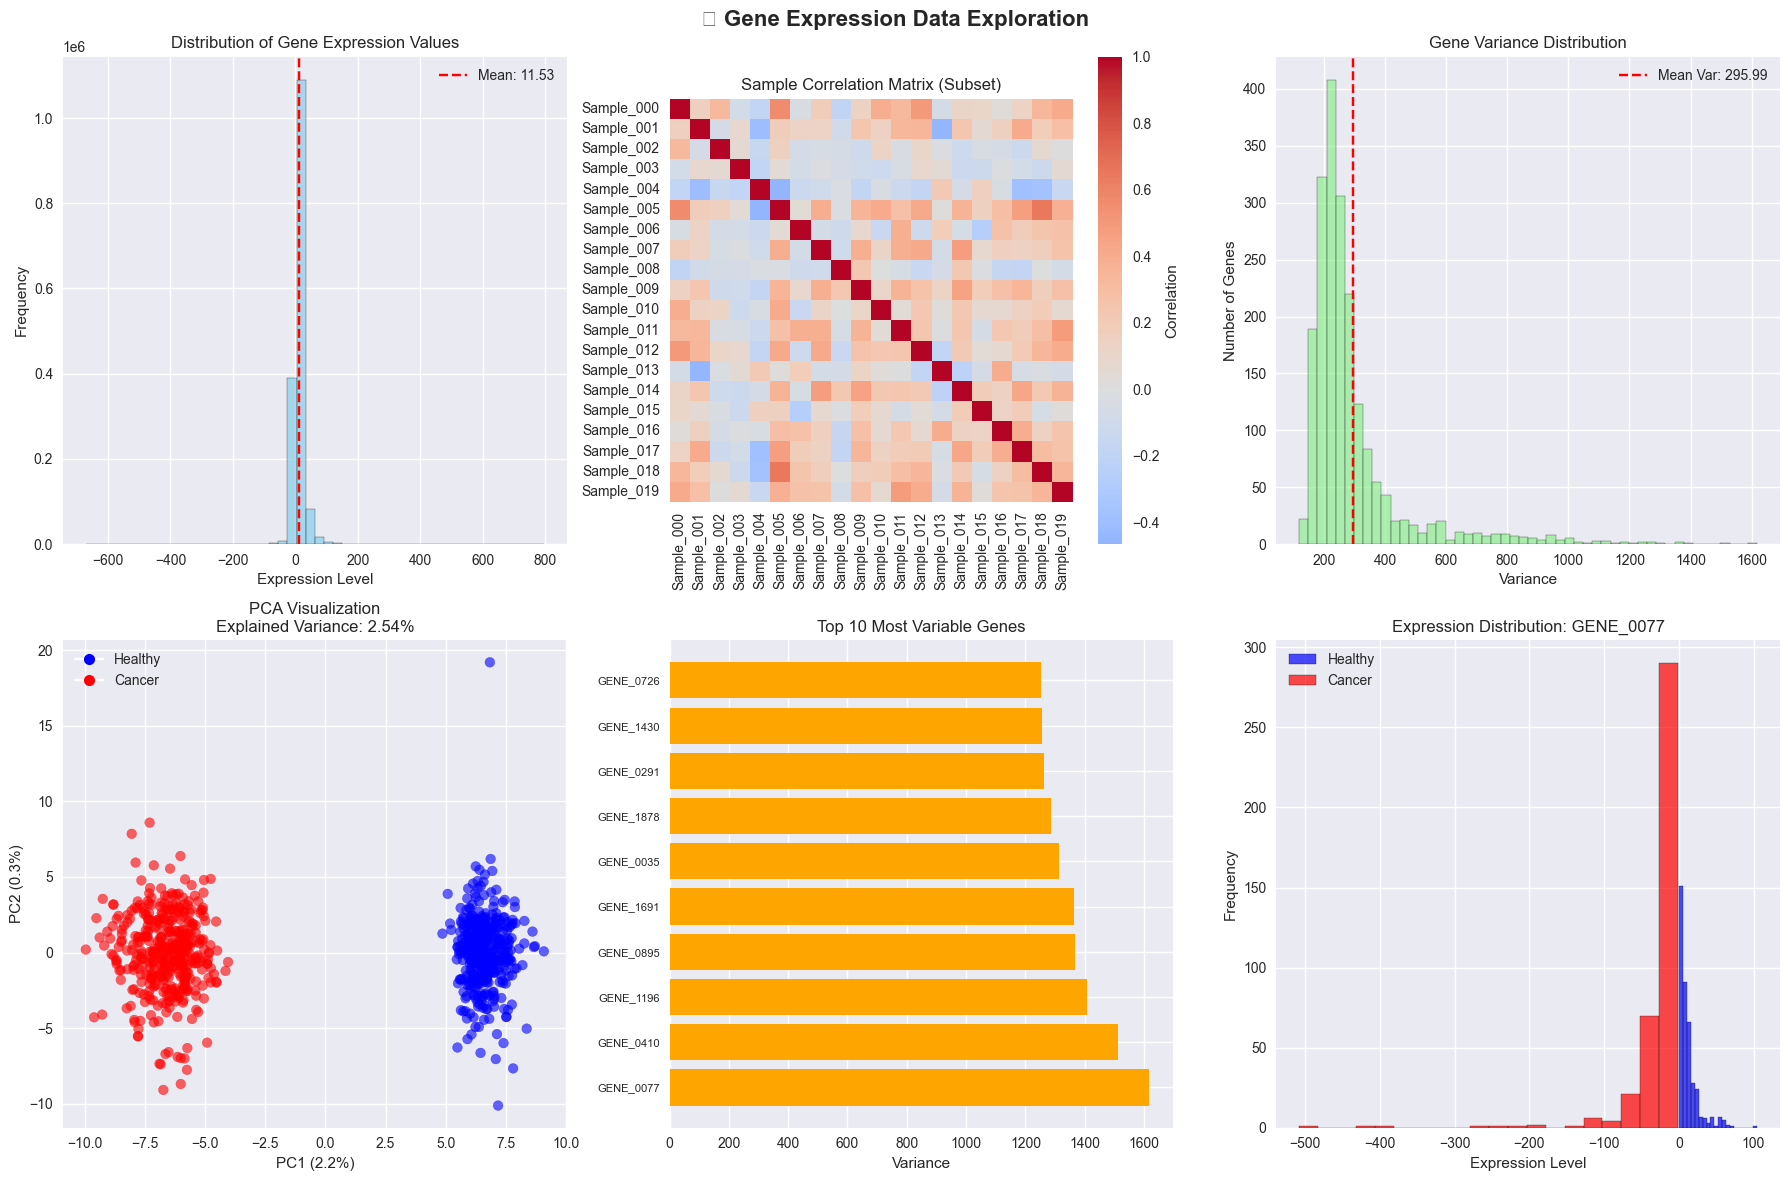


📈 Dataset Summary:
• Total samples: 800
• Total genes: 2000
• Cancer samples: 400
• Healthy samples: 400
• Mean expression: 11.53 ± 17.65
• Most variable gene: GENE_0077 (variance: 1617.82)
• PCA explains 2.5% of variance in first 2 components


In [3]:
def create_eda_plots(expression_df: pd.DataFrame, labels: pd.Series) -> None:
    """Create comprehensive EDA plots for gene expression data."""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🧬 Gene Expression Data Exploration', fontsize=16, fontweight='bold')
    
    # 1. Distribution of gene expression values
    axes[0, 0].hist(expression_df.values.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Gene Expression Values')
    axes[0, 0].set_xlabel('Expression Level')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(expression_df.values.mean(), color='red', linestyle='--', label=f'Mean: {expression_df.values.mean():.2f}')
    axes[0, 0].legend()
    
    # 2. Sample correlation heatmap (subset for visibility)
    sample_subset = expression_df.iloc[:20, :50]  # First 20 samples, 50 genes
    corr_matrix = sample_subset.T.corr()
    sns.heatmap(corr_matrix, ax=axes[0, 1], cmap='coolwarm', center=0, 
                square=True, cbar_kws={'label': 'Correlation'})
    axes[0, 1].set_title('Sample Correlation Matrix (Subset)')
    
    # 3. Gene variance distribution
    gene_variances = expression_df.var(axis=0)
    axes[0, 2].hist(gene_variances, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 2].set_title('Gene Variance Distribution')
    axes[0, 2].set_xlabel('Variance')
    axes[0, 2].set_ylabel('Number of Genes')
    axes[0, 2].axvline(gene_variances.mean(), color='red', linestyle='--', 
                       label=f'Mean Var: {gene_variances.mean():.2f}')
    axes[0, 2].legend()
    
    # 4. PCA visualization
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # Scale data for PCA
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(expression_df)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    # Color by cancer status
    colors = ['blue' if label == 0 else 'red' for label in labels]
    scatter = axes[1, 0].scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.6)
    axes[1, 0].set_title(f'PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.2%}')
    axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    
    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Healthy'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Cancer')]
    axes[1, 0].legend(handles=legend_elements)
    
    # 5. Top variable genes
    top_variable_genes = gene_variances.nlargest(10)
    axes[1, 1].barh(range(len(top_variable_genes)), top_variable_genes.values, color='orange')
    axes[1, 1].set_yticks(range(len(top_variable_genes)))
    axes[1, 1].set_yticklabels(top_variable_genes.index, fontsize=8)
    axes[1, 1].set_title('Top 10 Most Variable Genes')
    axes[1, 1].set_xlabel('Variance')
    
    # 6. Class separation example (top variable gene)
    top_gene = gene_variances.idxmax()
    gene_expression = expression_df[top_gene]
    
    cancer_expr = gene_expression[labels == 1]
    healthy_expr = gene_expression[labels == 0]
    
    axes[1, 2].hist(healthy_expr, bins=20, alpha=0.7, label='Healthy', color='blue', edgecolor='black')
    axes[1, 2].hist(cancer_expr, bins=20, alpha=0.7, label='Cancer', color='red', edgecolor='black')
    axes[1, 2].set_title(f'Expression Distribution: {top_gene}')
    axes[1, 2].set_xlabel('Expression Level')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📈 Dataset Summary:")
    print(f"• Total samples: {expression_df.shape[0]}")
    print(f"• Total genes: {expression_df.shape[1]}")
    print(f"• Cancer samples: {sum(labels == 1)}")
    print(f"• Healthy samples: {sum(labels == 0)}")
    print(f"• Mean expression: {expression_df.values.mean():.2f} ± {expression_df.values.std():.2f}")
    print(f"• Most variable gene: {top_gene} (variance: {gene_variances[top_gene]:.2f})")
    print(f"• PCA explains {pca.explained_variance_ratio_.sum():.1%} of variance in first 2 components")

# Create the EDA plots
create_eda_plots(expression_df, labels)


## 🧠 Neural Network Fundamentals

Before building our deep learning model, let's understand the key concepts:

### 1. **Perceptron (Basic Neuron)**
- Takes weighted inputs, adds bias, applies activation function
- `output = activation(Σ(weights × inputs) + bias)`

### 2. **Activation Functions**
- **ReLU**: `max(0, x)` - Most common, solves vanishing gradient
- **Sigmoid**: `1/(1+e^-x)` - Outputs between 0-1, can saturate
- **Tanh**: `tanh(x)` - Outputs between -1 to 1

### 3. **Loss Functions**
- **Binary Cross-Entropy**: For binary classification (cancer/healthy)
- **Mean Squared Error**: For regression tasks

### 4. **Backpropagation**
- Algorithm to update weights by propagating error backwards
- Uses chain rule to compute gradients

Let's implement a simple neural network from scratch to understand these concepts!


In [4]:
class SimpleNeuralNetwork(nn.Module):
    """
    A clean, production-ready neural network for gene expression classification.
    
    Follows modern PyTorch practices:
    - Type hints for clarity
    - Configurable architecture
    - Proper initialization
    - Dropout for regularization
    """
    
    def __init__(
        self, 
        input_dim: int, 
        hidden_dims: List[int] = [512, 256, 128],
        output_dim: int = 1,
        dropout_rate: float = 0.3,
        activation: str = 'relu'
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),  # Helps with training stability
                nn.ReLU() if activation == 'relu' else nn.Tanh(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        
        # Output layer (no activation - will use BCEWithLogitsLoss)
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights properly
        self._initialize_weights()
        
        logger.info(f"🧠 Created neural network: {input_dim} → {hidden_dims} → {output_dim}")
    
    def _initialize_weights(self) -> None:
        """Initialize weights using Xavier/He initialization."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        return self.network(x)
    
    def get_feature_importance(self, x: torch.Tensor) -> torch.Tensor:
        """Calculate feature importance using gradient-based method."""
        x.requires_grad_(True)
        output = self.forward(x)
        grad = torch.autograd.grad(output.sum(), x, create_graph=True)[0]
        return grad.abs().mean(dim=0)

# Let's also create a baseline model for comparison
class BaselineModels:
    """Traditional ML models for comparison with deep learning."""
    
    def __init__(self, random_state: int = RANDOM_STATE):
        self.random_state = random_state
        self.models = {
            'logistic_regression': LogisticRegression(
                random_state=random_state, 
                max_iter=1000,
                class_weight='balanced'
            ),
            'random_forest': RandomForestClassifier(
                n_estimators=100,
                random_state=random_state,
                class_weight='balanced',
                n_jobs=-1
            )
        }
        self.fitted_models = {}
        self.results = {}
    
    def fit_and_evaluate(self, X_train, X_test, y_train, y_test) -> Dict:
        """Fit all baseline models and return results."""
        for name, model in self.models.items():
            logger.info(f"🔧 Training {name}...")
            
            # Fit model
            model.fit(X_train, y_train)
            self.fitted_models[name] = model
            
            # Predictions
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
            
            # Metrics
            auc = roc_auc_score(y_test, y_prob)
            
            self.results[name] = {
                'auc': auc,
                'predictions': y_pred,
                'probabilities': y_prob
            }
            
            logger.info(f"✅ {name} AUC: {auc:.3f}")
        
        return self.results

print("🏗️ Neural network and baseline models defined!")


🏗️ Neural network and baseline models defined!


## 🔧 Data Preprocessing & Training Setup

Critical steps for working with biological data:
1. **Feature scaling** - Gene expression has different scales
2. **Train/validation/test splits** - Proper evaluation
3. **Handling high-dimensionality** - 2000 genes vs 800 samples
4. **Regularization** - Prevent overfitting

**💡 Workshop Discussion Point**: Why is scaling especially important for neural networks vs tree-based models?


In [5]:
# Data preprocessing pipeline
def prepare_data(expression_df: pd.DataFrame, labels: pd.Series, test_size: float = 0.2, val_size: float = 0.2):
    """
    Prepare data for training with proper scaling and splits.
    
    Returns train/val/test splits as both numpy arrays and PyTorch tensors.
    """
    logger.info("🔧 Preparing data for training...")
    
    # Convert to numpy
    X = expression_df.values
    y = labels.values
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
    )
    
    # Second split: train/validation from remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=RANDOM_STATE, stratify=y_temp
    )
    
    # Scale features (fit on training, transform all)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
    y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
    
    # Create data loaders for efficient batch processing
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    logger.info(f"✅ Data prepared - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    return {
        'arrays': {
            'X_train': X_train_scaled, 'X_val': X_val_scaled, 'X_test': X_test_scaled,
            'y_train': y_train, 'y_val': y_val, 'y_test': y_test
        },
        'tensors': {
            'X_train': X_train_tensor, 'X_val': X_val_tensor, 'X_test': X_test_tensor,
            'y_train': y_train_tensor, 'y_val': y_val_tensor, 'y_test': y_test_tensor
        },
        'loaders': {
            'train': train_loader, 'val': val_loader, 'test': test_loader
        },
        'scaler': scaler,
        'feature_names': expression_df.columns.tolist()
    }

# Prepare the data
data = prepare_data(expression_df, labels)

print(f"📊 Training set: {data['arrays']['X_train'].shape}")
print(f"📊 Validation set: {data['arrays']['X_val'].shape}")
print(f"📊 Test set: {data['arrays']['X_test'].shape}")
print(f"🎯 Class distribution in training: {np.bincount(data['arrays']['y_train'])}")
print(f"🎯 Class distribution in test: {np.bincount(data['arrays']['y_test'])}")


2025-09-26 15:21:34,502 - __main__ - INFO - 🔧 Preparing data for training...
2025-09-26 15:21:34,552 - __main__ - INFO - ✅ Data prepared - Train: 480, Val: 160, Test: 160


📊 Training set: (480, 2000)
📊 Validation set: (160, 2000)
📊 Test set: (160, 2000)
🎯 Class distribution in training: [240 240]
🎯 Class distribution in test: [80 80]


## 🚀 Training the Neural Network

Modern training practices for production systems:
- **Early stopping** - Stop when validation loss stops improving
- **Learning rate scheduling** - Adapt learning rate during training
- **Progress tracking** - Log metrics for observability
- **Checkpointing** - Save best model states

**💡 Key Concept**: The training loop is where the magic happens - forward pass, loss calculation, backpropagation, and weight updates!


In [6]:
class NeuralNetworkTrainer:
    """
    Production-ready training class with proper error handling, logging, and callbacks.
    """
    
    def __init__(self, model: nn.Module, device: str = 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'val_auc': []}
        self.best_val_auc = 0.0
        self.best_model_state = None
        
    def train_epoch(self, train_loader: DataLoader, optimizer: optim.Optimizer, criterion) -> float:
        """Train for one epoch."""
        self.model.train()
        total_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Update weights
            optimizer.step()
            
            total_loss += loss.item()
        
        return total_loss / len(train_loader)
    
    def validate(self, val_loader: DataLoader, criterion) -> Tuple[float, float]:
        """Validate the model."""
        self.model.eval()
        total_loss = 0.0
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                
                total_loss += loss.item()
                
                # Collect predictions for AUC calculation
                probs = torch.sigmoid(outputs).cpu().numpy()
                all_predictions.extend(probs.flatten())
                all_targets.extend(batch_y.cpu().numpy().flatten())
        
        val_loss = total_loss / len(val_loader)
        val_auc = roc_auc_score(all_targets, all_predictions)
        
        return val_loss, val_auc
    
    def fit(
        self, 
        train_loader: DataLoader, 
        val_loader: DataLoader,
        epochs: int = 100,
        lr: float = 0.001,
        patience: int = 10,
        verbose: bool = True
    ) -> Dict:
        """
        Train the model with early stopping and learning rate scheduling.
        """
        # Setup optimizer and loss function
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)
        criterion = nn.BCEWithLogitsLoss()
        
        best_val_auc = 0.0
        patience_counter = 0
        
        logger.info(f"🚀 Starting training for {epochs} epochs...")
        
        for epoch in range(epochs):
            # Training
            train_loss = self.train_epoch(train_loader, optimizer, criterion)
            
            # Validation
            val_loss, val_auc = self.validate(val_loader, criterion)
            
            # Learning rate scheduling
            scheduler.step(val_auc)
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_auc'].append(val_auc)
            
            # Early stopping logic
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                self.best_val_auc = val_auc
                self.best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Logging
            if verbose and (epoch + 1) % 10 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                logger.info(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | "
                          f"Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f} | LR: {current_lr:.6f}")
            
            # Early stopping
            if patience_counter >= patience:
                logger.info(f"🛑 Early stopping at epoch {epoch+1} (patience: {patience})")
                break
        
        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            logger.info(f"✅ Training completed. Best validation AUC: {self.best_val_auc:.4f}")
        
        return self.history

# Initialize and train the neural network
input_dim = data['arrays']['X_train'].shape[1]
model = SimpleNeuralNetwork(input_dim=input_dim, hidden_dims=[512, 256, 128])

trainer = NeuralNetworkTrainer(model)
history = trainer.fit(
    data['loaders']['train'], 
    data['loaders']['val'],
    epochs=100,
    lr=0.001,
    patience=15
)


2025-09-26 15:21:57,578 - __main__ - INFO - 🧠 Created neural network: 2000 → [512, 256, 128] → 1
2025-09-26 15:21:59,674 - __main__ - INFO - 🚀 Starting training for 100 epochs...
2025-09-26 15:22:02,233 - __main__ - INFO - Epoch  10 | Train Loss: 0.0052 | Val Loss: 0.0059 | Val AUC: 1.0000 | LR: 0.000500
2025-09-26 15:22:04,380 - __main__ - INFO - 🛑 Early stopping at epoch 16 (patience: 15)
2025-09-26 15:22:04,386 - __main__ - INFO - ✅ Training completed. Best validation AUC: 1.0000


## 📊 Model Evaluation & Comparison

Let's compare our neural network against traditional ML approaches and analyze the results!


2025-09-26 15:22:20,730 - __main__ - INFO - 🔧 Training logistic_regression...
2025-09-26 15:22:20,776 - __main__ - INFO - ✅ logistic_regression AUC: 1.000
2025-09-26 15:22:20,781 - __main__ - INFO - 🔧 Training random_forest...
2025-09-26 15:22:21,362 - __main__ - INFO - ✅ random_forest AUC: 1.000
/home/user/D/deepWork/.dlenv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) Arial.
  fig.canvas.draw()
/home/user/D/deepWork/.dlenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


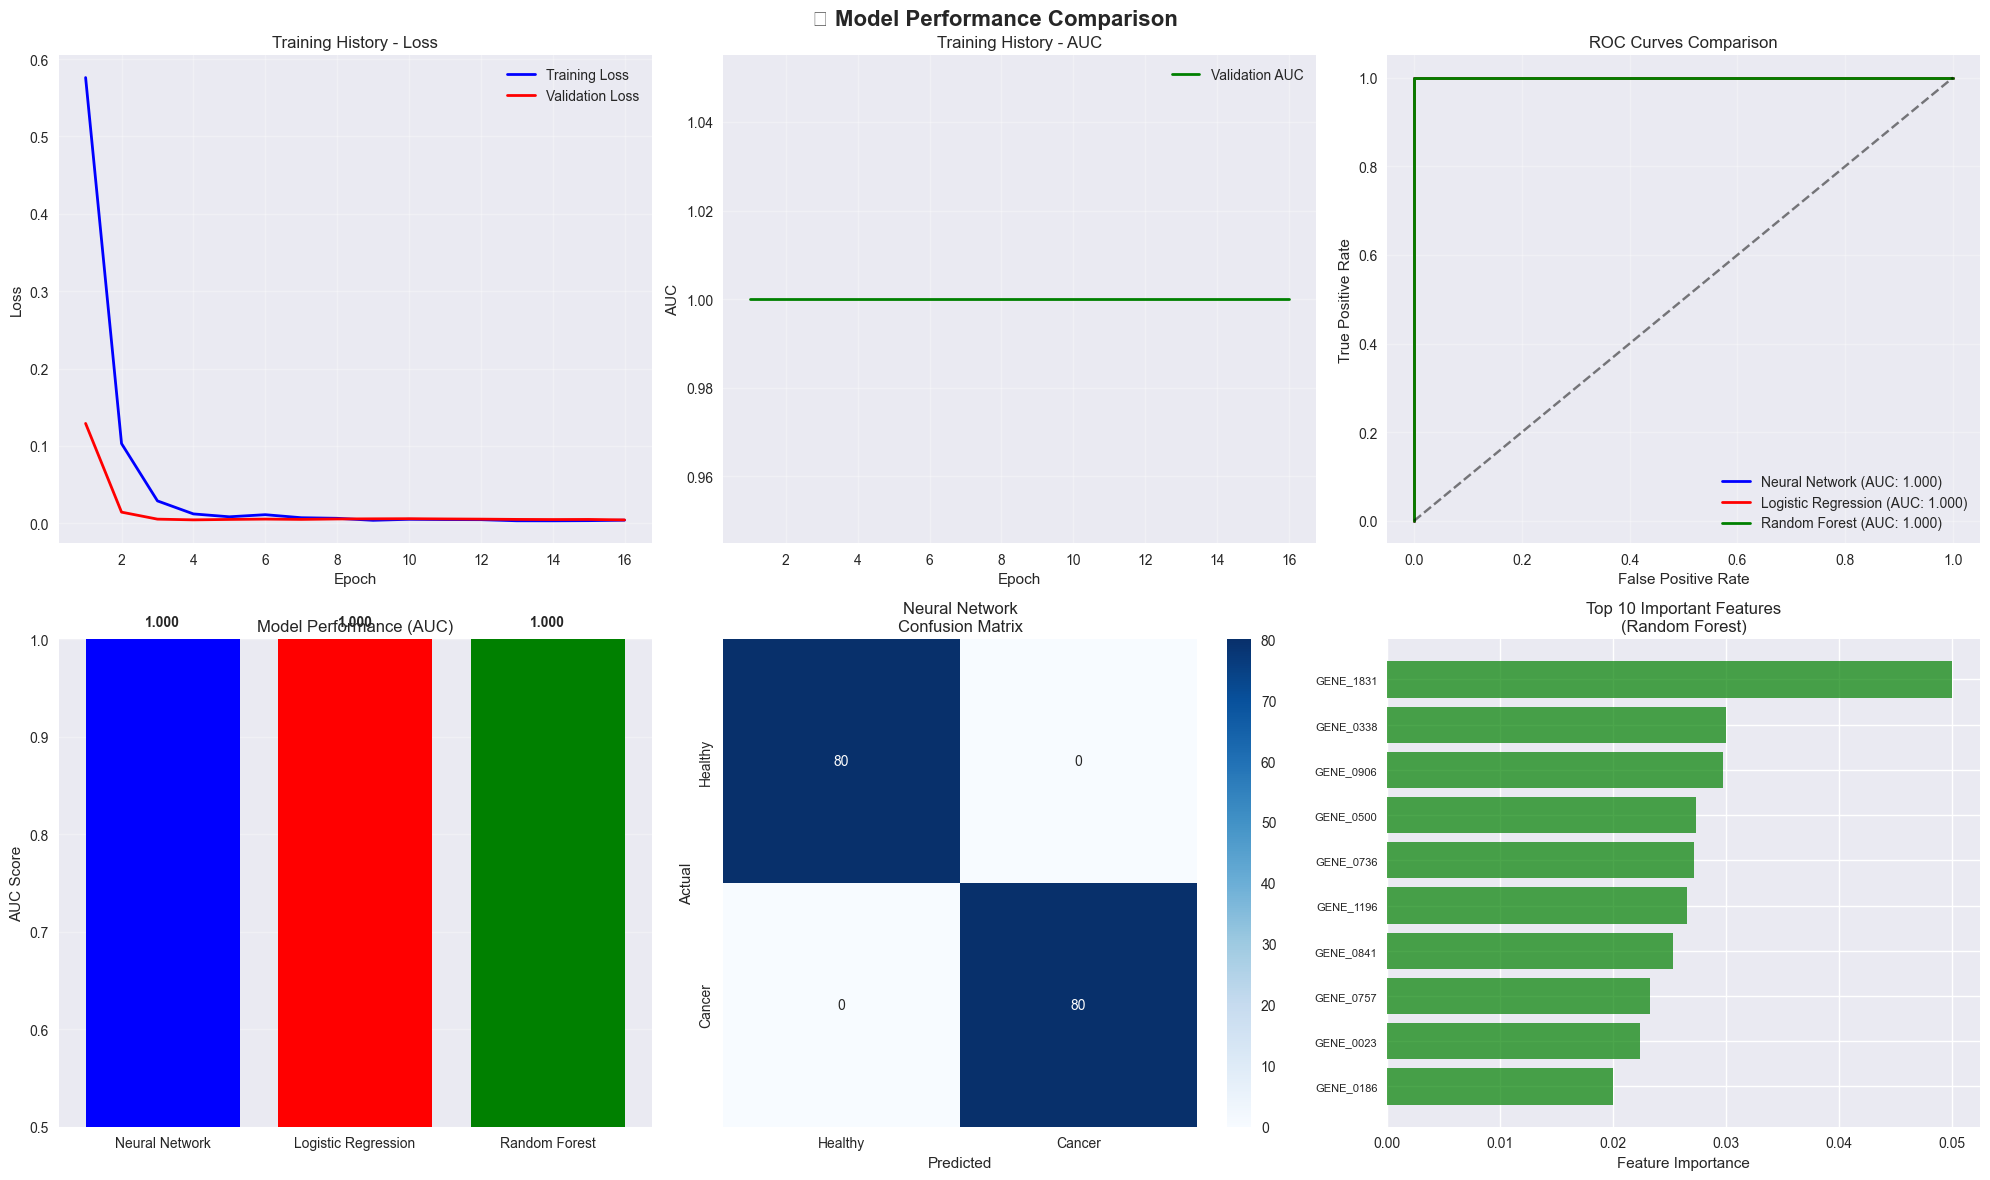


🏆 MODEL PERFORMANCE SUMMARY
Neural Network      | AUC: 1.0000
Logistic Regression | AUC: 1.0000
Random Forest      | AUC: 1.0000

📈 TRAINING SUMMARY
• Final training loss: 0.0040
• Best validation AUC: 1.0000
• Total epochs trained: 16
• Early stopping: Yes


In [7]:
# Train baseline models for comparison
baseline_models = BaselineModels()
baseline_results = baseline_models.fit_and_evaluate(
    data['arrays']['X_train'], 
    data['arrays']['X_test'],
    data['arrays']['y_train'], 
    data['arrays']['y_test']
)

# Evaluate neural network on test set
def evaluate_neural_network(model, test_loader, device='cpu'):
    """Evaluate the trained neural network."""
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_targets = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            
            outputs = model(batch_x)
            probabilities = torch.sigmoid(outputs).cpu().numpy()
            predictions = (probabilities > 0.5).astype(int)
            
            all_predictions.extend(predictions.flatten())
            all_probabilities.extend(probabilities.flatten())
            all_targets.extend(batch_y.numpy().flatten())
    
    return {
        'predictions': np.array(all_predictions),
        'probabilities': np.array(all_probabilities),
        'targets': np.array(all_targets),
        'auc': roc_auc_score(all_targets, all_probabilities)
    }

# Evaluate our neural network
nn_results = evaluate_neural_network(trainer.model, data['loaders']['test'])

# Create comprehensive comparison
def create_model_comparison(nn_results, baseline_results, history):
    """Create detailed model comparison plots."""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('🔬 Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Training history
    epochs = range(1, len(history['train_loss']) + 1)
    
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training History - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Validation AUC during training
    ax2 = axes[0, 1]
    ax2.plot(epochs, history['val_auc'], 'g-', label='Validation AUC', linewidth=2)
    ax2.set_title('Training History - AUC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. ROC Curves
    ax3 = axes[0, 2]
    
    # Neural Network ROC
    fpr_nn, tpr_nn, _ = roc_curve(nn_results['targets'], nn_results['probabilities'])
    ax3.plot(fpr_nn, tpr_nn, 'b-', linewidth=2, 
             label=f'Neural Network (AUC: {nn_results["auc"]:.3f})')
    
    # Baseline models ROC
    colors = ['red', 'green']
    for i, (name, results) in enumerate(baseline_results.items()):
        fpr, tpr, _ = roc_curve(data['arrays']['y_test'], results['probabilities'])
        ax3.plot(fpr, tpr, color=colors[i], linewidth=2, 
                 label=f'{name.replace("_", " ").title()} (AUC: {results["auc"]:.3f})')
    
    ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax3.set_title('ROC Curves Comparison')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. AUC Comparison Bar Chart
    ax4 = axes[1, 0]
    model_names = ['Neural Network'] + [name.replace('_', ' ').title() for name in baseline_results.keys()]
    auc_scores = [nn_results['auc']] + [results['auc'] for results in baseline_results.values()]
    
    bars = ax4.bar(model_names, auc_scores, color=['blue', 'red', 'green'])
    ax4.set_title('Model Performance (AUC)')
    ax4.set_ylabel('AUC Score')
    ax4.set_ylim(0.5, 1.0)
    
    # Add value labels on bars
    for bar, score in zip(bars, auc_scores):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Confusion Matrix for Neural Network
    ax5 = axes[1, 1]
    cm = confusion_matrix(nn_results['targets'], nn_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax5,
                xticklabels=['Healthy', 'Cancer'], yticklabels=['Healthy', 'Cancer'])
    ax5.set_title('Neural Network\nConfusion Matrix')
    ax5.set_xlabel('Predicted')
    ax5.set_ylabel('Actual')
    
    # 6. Feature importance (for comparison)
    ax6 = axes[1, 2]
    
    # Get feature importance from Random Forest
    rf_importance = baseline_models.fitted_models['random_forest'].feature_importances_
    top_indices = np.argsort(rf_importance)[-10:]
    top_features = [data['feature_names'][i] for i in top_indices]
    top_importance = rf_importance[top_indices]
    
    ax6.barh(range(len(top_features)), top_importance, color='green', alpha=0.7)
    ax6.set_yticks(range(len(top_features)))
    ax6.set_yticklabels(top_features, fontsize=8)
    ax6.set_title('Top 10 Important Features\n(Random Forest)')
    ax6.set_xlabel('Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\n🏆 MODEL PERFORMANCE SUMMARY")
    print("=" * 50)
    print(f"Neural Network      | AUC: {nn_results['auc']:.4f}")
    for name, results in baseline_results.items():
        print(f"{name.replace('_', ' ').title():<18} | AUC: {results['auc']:.4f}")
    
    print(f"\n📈 TRAINING SUMMARY")
    print("=" * 50)
    print(f"• Final training loss: {history['train_loss'][-1]:.4f}")
    print(f"• Best validation AUC: {max(history['val_auc']):.4f}")
    print(f"• Total epochs trained: {len(history['train_loss'])}")
    print(f"• Early stopping: {'Yes' if len(history['train_loss']) < 100 else 'No'}")

# Create the comparison
create_model_comparison(nn_results, baseline_results, history)


## 🎯 Workshop Activities & Discussion

### 💡 Hands-on Exercises (15-20 minutes)

Try these modifications and observe the results:

1. **Architecture Experiments**:
   - Change the network architecture (try `[256, 128]` or `[1024, 512, 256, 128]`)
   - Modify dropout rates (`0.1`, `0.5`, `0.7`)
   - Try different activation functions

2. **Hyperparameter Tuning**:
   - Adjust learning rate (`0.01`, `0.0001`)
   - Change batch size (`32`, `128`)
   - Modify weight decay

3. **Data Preprocessing**:
   - Try different scaling methods (MinMax, Robust)
   - Add feature selection (top 1000 most variable genes)

### 🤔 Discussion Questions

1. **When did deep learning outperform traditional ML?** What does this tell us about the data?

2. **Overfitting signs**: How can you tell if the model is overfitting? What would you do?

3. **Biological interpretation**: How might you explain which genes the model finds important?

4. **Production considerations**: What additional steps would be needed for a real clinical application?

### 🔬 Key Takeaways

✅ **Neural networks** can capture complex non-linear relationships in gene expression data  
✅ **Proper preprocessing** (scaling, validation splits) is crucial for biological data  
✅ **Regularization** (dropout, early stopping) prevents overfitting with small datasets  
✅ **Baseline comparison** helps validate that complexity is justified  
✅ **Production practices** (logging, checkpointing) are essential for real applications  

---

**Next**: In Module B, we'll explore CNN and RNN architectures for sequence data!
